# General framework:
- Generate some sample data and plot it
- Define a model with the following functions:
    - `__init__`: initialize the model, K, num_genes
    - `_fit_VI`: train the model, do inference of the model parameters using varitional inference
    - `_get_z`: Get the latent representation of the data
- Apply such a model on the sample data and plot the results

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import torch
seed = 0
torch.manual_seed(seed)
np.random.seed(seed)
p=2 #number of genes (input data dimension)
nf=1000 # number of samples in foreground group
nb=1000 # number of samples in background group
Ks=1 # number of shared factors
Kf=1 # number of foreground specific factors

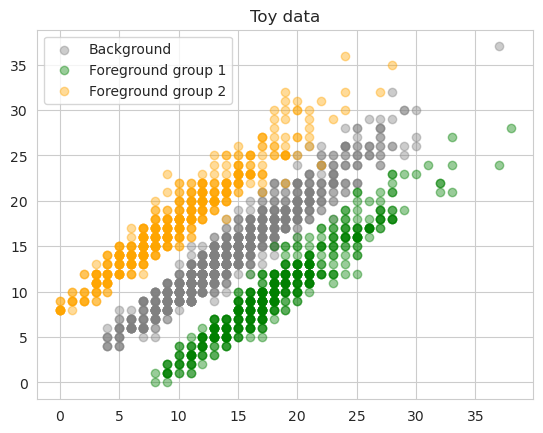

<Figure size 640x480 with 0 Axes>

In [9]:
Y = pd.read_csv("./data/toy_background.csv", header=None).values
X = pd.read_csv("./data/toy_foreground.csv", header=None).values
nf, nb = X.shape[0], Y.shape[0]
assert X.shape[1] == Y.shape[1]
p = X.shape[1]

# Plot the data
plt.scatter(Y[:, 0], Y[:, 1], label="Background", color="gray", alpha=0.4)
plt.scatter(X[:nf//2, 0], X[:nf//2, 1], label="Foreground group 1", color="green", alpha=0.4)
plt.scatter(X[nf//2:, 0], X[nf//2:, 1], label="Foreground group 2", color="orange", alpha=0.4)
plt.title("Toy data")
plt.legend()
plt.show()
plt.savefig("./figures/toy_data.png")

In [4]:
# Now define the model
import torch
from torch import nn
from torch.nn import functional as F
import importlib
import cplvm
importlib.reload(cplvm)


<module 'cplvm' from '/gladstone/engelhardt/home/hvu/source/Statistics_learning/cplvm.py'>

In [5]:
# now apply the model to the sample data
Kf=2
Ks=1
model = cplvm.CPLVM(p, Ks, Kf)
model._fit_VI(torch.tensor(X), torch.tensor(Y), 10000, 0.01)

100%|██████████| 10000/10000 [00:47<00:00, 210.50it/s]


([1218427.918921113,
  949912.3245589733,
  1387152.8540850878,
  717384.7125215773,
  847029.0649536848,
  2128514.066973567,
  1205019.9561977983,
  948500.1017115116,
  1295062.622931242,
  844111.4160062168,
  1320869.096362114,
  631484.9218755662,
  1085901.6311413646,
  856459.2998107076,
  247597.8459164612,
  213703.67679935694,
  1207511.7955652475,
  304007.24151551723,
  381477.7918139994,
  725290.2529190779,
  348511.40356749296,
  292614.61588072777,
  516546.5873847008,
  553052.0012966457,
  536452.0172345638,
  255981.65045884252,
  1045980.174377203,
  301838.92413693666,
  681503.617688179,
  241102.31455356255,
  256545.23776945285,
  334758.40071225166,
  369895.5739419013,
  374230.02901118994,
  442641.18074955046,
  311873.7895177603,
  184952.9861245508,
  666760.4138837457,
  229932.41957477853,
  133412.89920252562,
  93773.87521686405,
  39082.15832715202,
  592293.3181371242,
  278829.3170233369,
  187854.02658702433,
  48100.615968854865,
  247778.0850823

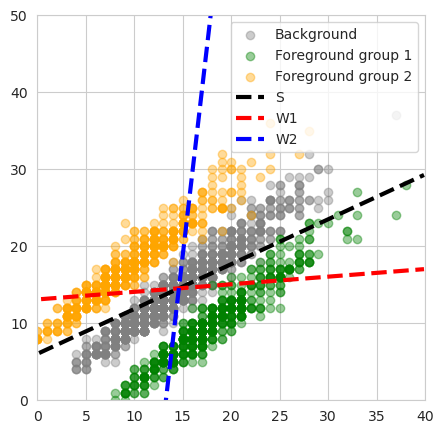

In [10]:
plt.figure(figsize=(5, 5))
import utils_dist as utils

# Plot data
plt.scatter(Y[:, 0], Y[:, 1], label="Background", color="gray", alpha=0.4)
plt.scatter(
    X[: nf // 2, 0], X[: nf // 2, 1], label="Foreground group 1", color="green", alpha=0.4
)
plt.scatter(
    X[nf // 2 :, 0], X[nf // 2 :, 1], label="Foreground group 2", color="orange", alpha=0.4,
)

axes = plt.gca()
xlims = np.array(axes.get_xlim())
ylims = np.array(axes.get_ylim())

# Plot S
Y_mean = np.mean(Y, axis=0)
S = utils.reparametrize_log_normal(model.qs_mu, model.qs_sigma).detach().numpy()
# S = np.exp(model.qs_mu.detach().numpy())
S_slope = S[0, 1] / S[0, 0]
S_intercept = Y_mean[1] - Y_mean[0] * S_slope
x_vals = np.linspace(xlims[0], xlims[1], 100)
y_vals = S_slope * x_vals + S_intercept
plt.plot(x_vals, y_vals, "--", label="S", color="black", linewidth=3)

# Plot W
X_mean = np.mean(X, axis=0)

W = utils.reparametrize_log_normal(model.qw_mu, model.qw_sigma).detach().numpy()
# W = np.exp(model.qw_mu.detach().numpy())
W_slope = W[0, 1] / W[0, 0]
W_intercept = Y_mean[1] - Y_mean[0] * W_slope
y_vals = np.linspace(ylims[0], ylims[1], 100)
y_vals = W_slope * x_vals + W_intercept
plt.plot(x_vals, y_vals, "--", label="W1", color="red", linewidth=3)


W_slope = W[1, 1] / W[1, 0]
W_intercept = Y_mean[1] - Y_mean[0] * W_slope
y_vals = np.linspace(ylims[0], ylims[1], 100)
y_vals = W_slope * x_vals + W_intercept
plt.plot(x_vals, y_vals, "--", label="W2", color="blue", linewidth=3)

plt.legend()
# set xlim and ylim
plt.xlim(0, 40)
plt.ylim(0, 50)
plt.savefig("figures/toy_data_inferred.png")

# Other code that I experimented with, to be ignored

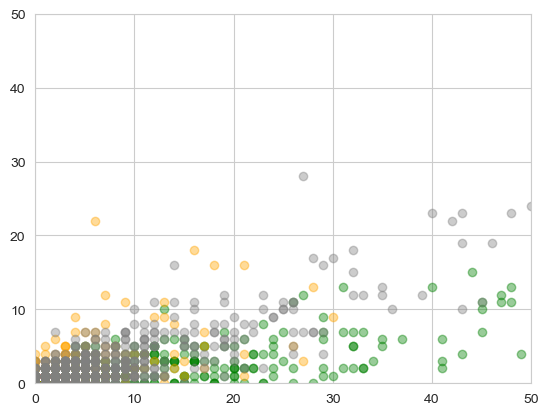

In [1]:
# the model should be constructed as follows:
'''
- X_{cells*genes}: foreground expression matrix
- Y_{cells*genes}: background expression matrix
- Zf_{cells*Ks}: Shared latent representation of the foreground cells
- Zb_{cells*Ks}: Shared latent representation of the background cells
- T_{cells*Kf}: latent representation of the cells that are specific to the foreground cells
- S_{genes*K}: gene loadings, shared between foreground and background
- W_{genes*K}: gene loadings, specific to foreground
- alpha_{cells}: cell-specific scaling factor. Most of the time we can think of this as the total count of reads in each cell
'''
# first, sample \mu for foreground and background data
# \mu ~ multivariate normal(0, identity), dimension: p. mu should be shared across samples
mu_f = np.random.multivariate_normal(np.zeros(p), np.eye(p), 1) # (1, p)
mu_b = np.random.multivariate_normal(np.zeros(p), np.eye(p), 1) # (1, p)
# sample the matrices S and W
# S ~ multivariate normal(0, identity), dimension: p, Ks samples
# W ~ multivariate normal(0, identity), dimension: p, Kf samples
S = np.random.multivariate_normal(np.zeros(p), np.eye(p), Ks) # (Ks, p)
W = np.random.multivariate_normal(np.zeros(p), np.eye(p), Kf) # (Kf, p)
# sample the latent variables Zf and Zb
# Z ~ multivariate normal(0, identity), dimension Ks, nf and nb samples
Zf = np.random.multivariate_normal(np.zeros(Ks), np.eye(Ks), nf) # (nf, Ks)
Zb = np.random.multivariate_normal(np.zeros(Ks), np.eye(Ks), nb) # (nb, Ks)
# sample the foreground-specific latent variables T
# the first half of cells should have T from normal with means -1
# the second half of cells should have T from normal with means 1
T = np.random.multivariate_normal(np.full(Kf,-1), np.eye(Kf), nf//2)
T = np.concatenate((T, np.random.multivariate_normal(np.full(Kf,1), np.eye(Kf), nf//2)))
# sample cell-specific scaling factors alpha
# alpha ~ lognormal(random numbers representing the total count per cells, I)
# but for now, we keep this to be 0 for simplicity
alpha_f = np.random.lognormal(0, 1, nf)  
alpha_b = np.random.lognormal(0, 1, nb)
# sample the expression matrices X and Y
X = (Zf@S) + (T@W) + mu_f + np.log(alpha_f[:, np.newaxis]) # (nf, p)
Y = (Zb@S) + mu_b + np.log(alpha_b[:, np.newaxis]) # (nb, p)
# transform X and Y as Poisson(exp(X)) and Poisson(exp(Y))
X = np.random.poisson(np.exp(X))
Y = np.random.poisson(np.exp(Y))
# plot the data
plt.scatter(X[:nf//2, 0], X[:nf//2, 1], label="Foreground group 1", color="green", alpha=0.4)
plt.scatter(X[nf//2:, 0], X[nf//2:, 1], label="Foreground group 2", color="orange", alpha=0.4)
plt.scatter(Y[:, 0], Y[:, 1], label="Background", color="gray", alpha=0.4)
# set xlim and ylim
plt.xlim(0, 50)
plt.ylim(0, 50)
plt.show()

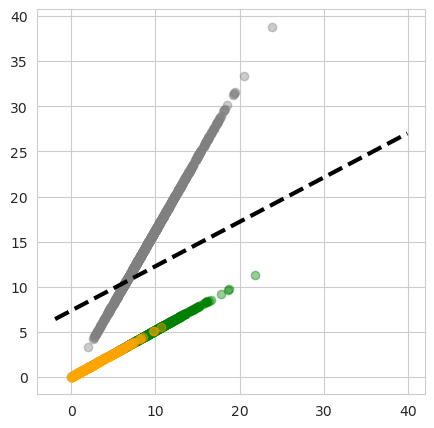

In [40]:
# 1, plot the alpha * Wt
z_b = utils.reparametrize_log_normal(model.qzb_mu, model.qzb_sigma) # (nb, Ks)
z_f = utils.reparametrize_log_normal(model.qzf_mu, model.qzf_sigma) # (nf, Ks)
t = utils.reparametrize_log_normal(model.qt_mu, model.qt_sigma) # (nf, Kf)
s = utils.reparametrize_log_normal(model.qs_mu, model.qs_sigma)  # (Ks, p)
w = utils.reparametrize_log_normal(model.qw_mu, model.qw_sigma)  # (Kf, p)
alpha_f = utils.reparametrize_log_normal(model.qalphaf_mu, model.qalphaf_sigma) # (nf)
alpha_b = utils.reparametrize_log_normal(model.qalphab_mu, model.qalphab_sigma) # (nb)
delta = utils.reparametrize_log_normal(model.qdelta_mu, model.qdelta_sigma)  # (p, 1)

plt.figure(figsize=(5, 5))
Y_hat = (alpha_b * delta).T * (z_b @ s)
Y_hat = Y_hat.detach().numpy()
plt.scatter(Y_hat[:, 0], Y_hat[:, 1], label="Background", color="grey", alpha=0.4)
S = utils.reparametrize_log_normal(model.qs_mu, model.qs_sigma).detach().numpy()
# S = np.exp(model.qs_mu.detach().numpy())
S_slope = S[0, 1] / S[0, 0]
S_intercept = Y_mean[1] - Y_mean[0] * S_slopeX_mean = np.mean(X, axis=0)

W = utils.reparametrize_log_normal(model.qw_mu, model.qw_sigma).detach().numpy()
# W = np.exp(model.qw_mu.detach().numpy())
W_slope = W[0, 1] / W[0, 0]
W_intercept = X_mean[1] - X_mean[0] * W_slope
y_vals = np.linspace(ylims[0], ylims[1], 100)
y_vals = W_slope * x_vals + W_intercept
plt.plot(x_vals, y_vals, "--", label="W1", color="red", linewidth=3)


W_slope = W[1, 1] / W[1, 0]
W_intercept = X_mean[1] - X_mean[0] * W_slope
y_vals = np.linspace(ylims[0], ylims[1], 100)
y_vals = W_slope * x_vals + W_intercept
plt.plot(x_vals, y_vals, "--", label="W2", color="blue", linewidth=3)


x_vals = np.linspace(xlims[0], xlims[1], 100)
y_vals = S_slope * x_vals + S_intercept
plt.plot(x_vals, y_vals, "--", label="S", color="black", linewidth=3)
X_hat_background = (alpha_f.view(-1,1)) * (z_f @ s)
X_hat_background = X_hat_background.detach().numpy()
plt.scatter(X_hat_background[:nf//2, 0], X_hat_background[:nf//2, 1], label="Foreground group 1", color="green", alpha=0.4)
plt.scatter(X_hat_background[nf//2:, 0], X_hat_background[nf//2:, 1], label="Foreground group 2", color="orange", alpha=0.4)
# plot t  
# t = t.detach().numpy()
# plt.scatter(t[:nf//2, 0], t[:nf//2, 1], label="F1", color="orange", alpha=0.4)
# plt.scatter(t[nf//2:, 0], t[nf//2:, 1], label="F2", color="green", alpha=0.4)
# 2. Plot the shared data alpha * S*z
# plot_data = (alpha_f.view(-1,1)) * (z_f @ s)
# plot_data = plot_data.detach().numpy()
# plt.scatter(plot_data[:nf//2, 0], plot_data[:nf//2, 1], label="F1", color="#808080", alpha=0.4)
# plt.scatter(plot_data[nf//2:, 0], plot_data[nf//2:, 1], label="F2", color="#808080", alpha=0.4)

In [8]:

import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm
from scipy.stats import multivariate_normal
from scipy.stats import poisson

import matplotlib

############ Generate data ############

# Covariance of RVs
cov_mat = np.array([[2.7, 2.6], [2.6, 2.7]])

n, m = 1000, 1000
p = 2


############ Generate data ############

Z = multivariate_normal.rvs(mean=np.zeros(p), cov=cov_mat, size=m // 2)
Z_tilde = norm.cdf(Z)  # for each values of Z (1D, not even 2D), calculate the CDF (P(Z<z) where Z ~ Normal(0,1))
Y1 = poisson.ppf(q=Z_tilde, mu=10)
Y1[:, 0] += 8

Z = multivariate_normal.rvs(mean=np.zeros(p), cov=cov_mat, size=m // 2)
Z_tilde = norm.cdf(Z)
Y2 = poisson.ppf(q=Z_tilde, mu=10)
Y2[:, 1] += 8
Y = np.concatenate([Y1, Y2], axis=0)

# # Generate latent variables
Z = multivariate_normal.rvs(mean=np.zeros(p), cov=cov_mat, size=n)

# Pass through standard normal CDF
Z_tilde = norm.cdf(Z)

# Inverse of observed distribution function
X = poisson.ppf(q=Z_tilde, mu=10)
X += 4

# Pre-standardized data
X_standardized = (X - X.mean(0)) / X.std(0)
Y_standardized = (Y - Y.mean(0)) / Y.std(0)

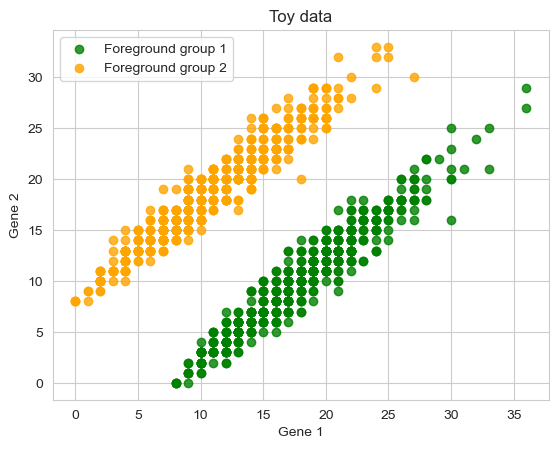

In [9]:

# plt.scatter(X[:, 0], X[:, 1], label="Background", color="gray", alpha=0.8)
plt.scatter(
    Y[: m // 2, 0], Y[: m // 2, 1], label="Foreground group 1", color="green", alpha=0.8
)
plt.scatter(
    Y[m // 2 :, 0],
    Y[m // 2 :, 1],
    label="Foreground group 2",
    color="orange",
    alpha=0.8,
)
plt.title("Toy data")
plt.xlabel("Gene 1")
plt.ylabel("Gene 2")
plt.legend()

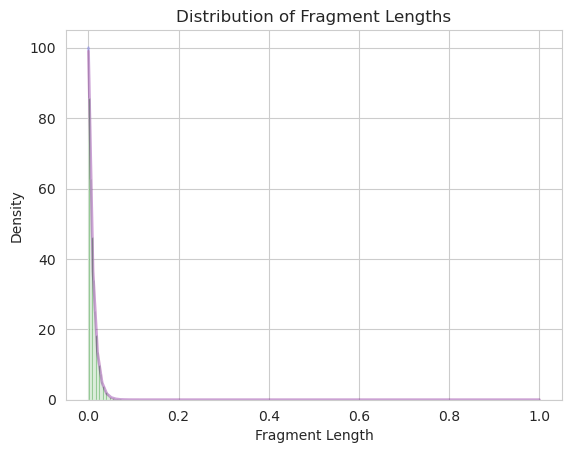

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import beta
from scipy.stats import expon
def simulate_fragmentation(n, simulations=1000):
    fragment_lengths = []
    for _ in range(simulations):
        break_points = np.random.rand(n-1)
        break_points = np.append(break_points, [0, 1])
        break_points.sort()
        lengths = np.diff(break_points)
        fragment_lengths.extend(lengths)
    return fragment_lengths

# Simulate fragmentation into 5 parts, 10000 times
n = 100
fragment_lengths = simulate_fragmentation(n, simulations=10000)

# plot the beta distribution
x = np.linspace(0, 1, 100)
y = beta.pdf(x, 1, n-1)
plt.plot(x, y, 'r-', lw=2, label=f'Beta(1, {n-1}) Distribution', alpha =0.2)

# plot the exponential distribution
x = np.linspace(0, 1, 100)
y = expon.pdf(x, scale=1/n)
plt.plot(x, y, 'b-', lw=2, label=f'Exponential(1/{n}) Distribution', alpha=0.2)

# Plot the distribution of fragment lengths
plt.hist(fragment_lengths, bins=50, density=True, alpha=0.6, color='g')
plt.title('Distribution of Fragment Lengths')
plt.xlabel('Fragment Length')
plt.ylabel('Density')
plt.show()
